# Лаборная работа 4

### Задание

Объект движется на шюскости $\mathbb{R}^2$ согласно следующему закону:
$$
\mathbf{x}_{n+1}=\mathbf{A} \mathbf{x}_n+\mathbf{B} \mathbf{u}_n+\mathbf{C} \mathbf{w}_{n+1}
$$

где
- $\mathbf{x}_n=\left(x_n^1, \dot{x}_n^1, \ddot{x}_n^1, x_n^2, \dot{x}_n^2, \ddot{x}_n^2\right)$ - вектор состояния отслеживаемого обьекта: $\left(x_n^1, x_n^2\right)$ - координаты обьекта; $\left(\dot{x}_n^1, \dot{x}_n^2\right)$ - вектор скорости; $\left(\ddot{x}_n^1, \ddot{x}_n^2\right)$ - вектор ускорения.
- $\left\{\mathbf{u}_n\right\}$ - управляющие команды, которые моделируются марковской цепью с множеством сосгояний
$$
\left\{(0,0)^T,(3.5,0)^T,(0,3.5)^T,(-3.5,0)^T,(0,-3.5)^T\right\}
$$

и матрицей переходных вероятностей
$$
\mathbf{P}=\frac{1}{20}\left(\begin{array}{ccccc}
16 & 1 & 1 & 1 & 1 \\
1 & 16 & 1 & 1 & 1 \\
1 & 1 & 16 & 1 & 1 \\
1 & 1 & 1 & 16 & 1 \\
1 & 1 & 1 & 1 & 16
\end{array}\right)
$$
- $\left\{\mathbf{w}_n\right\}$ - последовательность независимых с. в., имеющих распределение $\mathcal{N}\left(\mathbf{0}_{2 \times 1}, \sigma^2 \mathbf{I}\right)$, $\sigma=0.5$.
$$
\mathbf{A}=\left(\begin{array}{cc}
\tilde{\mathbf{A}} & \mathbf{0}_{3 \times 3} \\
\mathbf{0}_{3 \times 3} & \tilde{\mathbf{A}}
\end{array}\right), \quad \mathbf{B}=\left(\begin{array}{cc}
\tilde{\mathbf{B}} & \mathbf{0}_{3 \times 1} \\
\mathbf{0}_{3 \times 1} & \tilde{\mathbf{B}}
\end{array}\right), \quad \mathbf{C}=\left(\begin{array}{cc}
\tilde{\mathbf{C}} & \mathbf{0}_{3 \times 1} \\
\mathbf{0}_{3 \times 1} & \tilde{\mathbf{C}}
\end{array}\right)
$$

где
$$
\tilde{\mathbf{A}}=\left(\begin{array}{ccc}
1 & \Delta l & \Delta l^2 / 2 \\
0 & 1 & \Delta l \\
0 & 0 & \alpha
\end{array}\right), \quad \tilde{\mathbf{B}}=\left(\begin{array}{c}
\Delta l^2 / 2 \\
\Delta l \\
0
\end{array}\right), \quad \tilde{\mathbf{C}}=\left(\begin{array}{c}
\Delta l^2 / 2 \\
\Delta t \\
1
\end{array}\right)
$$
$\Delta t=0.5$ - период дискретизации; параметр $\alpha=0.6$.
На'альный вектор $\mathbf{x}_0$ имеет распределение $\mathcal{N}\left(\mathbf{0}_{6 \times 1}, \operatorname{diag}(500,5,5,200,5,5)\right) ; \mathbf{u}_0$ имеет равномерное расиределение на множестве (2).

Преднолагается, 'то обьект движется в зоне покрытия $L$ базовых станций с известными координатами $\mathbf{z}^{(\ell)}=\left(z_1^{(\ell)}, z_2^{(\ell)}\right), \quad \ell=1, \ldots, L$. Координаты $L=6$ базовых станций заиисаны в файле stations.txt. На мобильном объекте установлено принимающее устройство, которое регистрирует сигналы от базовых станций. Положение мобильного обьекта определяется на основе показателя уровня принимаемого сиг нала (RSSI - Received Signal Strength Indicator). Предюолагается следующая модель наблюдения, согласно которой регистрируемая мощность сигнала (в децибелах) определяетм соотношением:
$$
y_n^{\ell}=P_0-10 \beta \lg d_{\ell, n}+v_n^{\ell}, \quad \ell=1, \ldots, L
$$

где $P_0=90(д Б)-$ мощность сигнала, передаваемого базовой станцией; $\beta=3-$ коэффициент, характеризующий среду распространения сигнала; $d_{\ell, n}$ - расстояние от базовой станции $\ell$ до мобильного обьекта в момент времени $n ;\left\{v_n^{\ell}\right\}_{\ell=1}^L$ - независимые нормально распределенные слулайные вели'иины с нулевым средним и стандартным отклонением $\delta=1.5$ (дБ).

В файле RSSI-measurements.txt занисаны измерения RSSI от всех базовых станций: $\mathbf{y}_{0: m}^{\ell}=\left(y_0^{\ell}, \ldots, y_m^{\ell}\right), \ell=1, \ldots, L$. Требуется с помощью фильтра частиц восстановить траекторию мобильного обьекта.


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [100]:
# Базовые станции 
stations_data = np.loadtxt('./lab_files/stations.txt')  
stations = stations_data.reshape(-1, 2)     # Преобразование в массив 6x2

# Измерения RSSI
RSSI_measurements = np.loadtxt('./lab_files/RSSI-measurements.txt')  # L x m
L, m = stations.shape[0], RSSI_measurements.shape[0]

In [101]:
# Параметры модели
dt = 0.5
alpha = 0.6
sigma_w = 0.5
sigma_v = 1.5
P0 = 90
beta = 3

In [102]:
# Матрицы модели движения
A = np.block([
    [np.array([[1, dt, dt**2/2], [0, 1, dt], [0, 0, alpha]]), np.zeros((3, 3))],
    [np.zeros((3, 3)), np.array([[1, dt, dt**2/2], [0, 1, dt], [0, 0, alpha]])]
])
B = np.block([
    [np.array([[dt**2/2], [dt], [0]]), np.zeros((3, 1))],
    [np.zeros((3, 1)), np.array([[dt**2/2], [dt], [0]])]
])
C = np.block([
    [np.array([[dt**2/2], [dt], [1]]), np.zeros((3, 1))],
    [np.zeros((3, 1)), np.array([[dt**2/2], [dt], [1]])]
])

In [103]:
# Управление и матрица переходов
U = np.array([[0, 0], [3.5, 0], [0, 3.5], [-3.5, 0], [0, -3.5]])
P_transition = np.full((5, 5), 1/20)
np.fill_diagonal(P_transition, 16/20)

In [104]:
# Инициализация частиц
N_particles = 10000
particles = np.zeros((N_particles, 6))

# Координата x1 ~ N(0, sqrt(500))
particles[:, 0] = np.random.normal(0, np.sqrt(500), N_particles)
# Скорость x1_dot ~ N(0, sqrt(5))  
particles[:, 1] = np.random.normal(0, np.sqrt(5), N_particles)
# Ускорение x1_ddot ~ N(0, sqrt(5))
particles[:, 2] = np.random.normal(0, np.sqrt(5), N_particles)
# Координата x2 ~ N(0, sqrt(200))
particles[:, 3] = np.random.normal(0, np.sqrt(200), N_particles)
# Скорость x2_dot ~ N(0, sqrt(5))
particles[:, 4] = np.random.normal(0, np.sqrt(5), N_particles)
# Ускорение x2_ddot ~ N(0, sqrt(5))
particles[:, 5] = np.random.normal(0, np.sqrt(5), N_particles)

# Инициализация весов и управлений
weights = np.ones(N_particles) / N_particles
u_idx = np.random.randint(0, 5, N_particles)  # Случайные начальные управления

# Траектория
trajectory = np.zeros((m, 2))

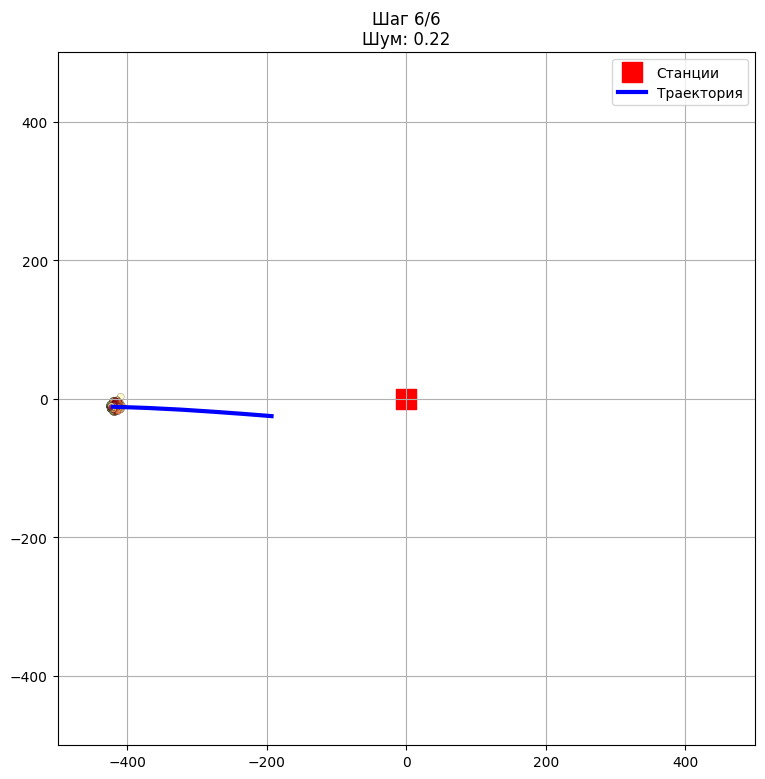

In [109]:
# Настройка графики
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(stations[:,0], stations[:,1], c='red', s=200, marker='s', label='Станции')
GRAPH_SIZE = 500
ax.set_xlim(-GRAPH_SIZE, GRAPH_SIZE)
ax.set_ylim(-GRAPH_SIZE, GRAPH_SIZE)
ax.grid(True)
ax.legend()

# Увеличим начальный разброс частиц
particles[:, 0] = np.random.normal(0, np.sqrt(500)*2, N_particles)  # x1
particles[:, 3] = np.random.normal(0, np.sqrt(200)*2, N_particles)  # x2

for n in range(m):
    # 1. Предсказание с увеличенным шумом
    for i in range(N_particles):
        u_idx[i] = np.random.choice(5, p=P_transition[u_idx[i]])
        u = U[u_idx[i]]
        w = np.random.normal(0, sigma_w*1.5, 2)  # Увеличенный шум
        particles[i] = A @ particles[i] + B @ u + C @ w

    # 2. Взвешивание (логарифмическая шкала)
    log_weights = np.zeros(N_particles)
    for i in range(N_particles):
        x1, x2 = particles[i, 0], particles[i, 3]
        for l in range(L):
            d = np.sqrt((x1 - stations[l, 0])**2 + (x2 - stations[l, 1])**2)
            y_pred = P0 - 10 * beta * np.log10(d + 1e-9)  
            log_weights[i] += -0.5 * ((RSSI_measurements[n, l] - y_pred) / sigma_v)**2
    
    # Нормализация весов
    weights = np.exp(log_weights - np.max(log_weights))
    weights /= np.sum(weights)

    # Проверка на случай, когда веса частиц очень близки к нулю
    weights = np.maximum(weights, 1e-9)
    weights /= np.sum(weights)
    
    # 3. Перевыборка с адаптивным шумом
    indices = np.random.choice(N_particles, size=N_particles, p=weights)
    particles = particles[indices]
    u_idx = u_idx[indices]
    
    # Адаптивный шум в зависимости от дисперсии
    position_std = np.std(particles[:, [0, 3]], axis=0)
    noise_scale = np.max(position_std)/10  # Динамический масштаб шума
    noise_scale = np.maximum(noise_scale, 1e-3)  # Минимальный шум
    
    particles += np.random.normal(0, noise_scale, particles.shape)

    # 4. Оценка состояния
    trajectory[n] = np.average(particles[:, [0, 3]], axis=0, weights=weights)
    
    # Визуализация
    clear_output(wait=True)
    ax.clear()
    
    # Станции
    ax.scatter(stations[:,0], stations[:,1], c='red', s=200, marker='s', label='Станции')
    
    # Частицы с цветом и размером по весам
    norm_weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
    colors = plt.cm.RdYlGn(norm_weights)  # Зеленый - высокий вес, Красный - низкий
    sizes = 10 + norm_weights * 35  # Размер от 10 до 35
    
    ax.scatter(particles[:,0], particles[:,3], c=colors, s=sizes, alpha=0.7, 
               edgecolors='k', linewidths=0.2)
    
    # Траектория
    ax.plot(trajectory[:n+1,0], trajectory[:n+1,1], 'b-', linewidth=3, label='Траектория')
    ax.set_title(f'Шаг {n+1}/{m}\nШум: {noise_scale:.2f}')
    ax.set_xlim(-GRAPH_SIZE, GRAPH_SIZE)
    ax.set_ylim(-GRAPH_SIZE, GRAPH_SIZE)
    ax.grid(True)
    ax.legend()
    
    display(fig)
    time.sleep(0.5)

plt.close()